## 4. Combining raster and vector data

Raster and vectors can be processed together using the _runVectorScript_ function. This script runs over each geometry element in a Vector (polygons, lines or points). This allows any Vector propreties on the geometry to be referenced by name and additionally allows multiple Rasters to be referenced. However, the value returned for a Raster is now _a many-to-one aggregation of the cells within the Vector geometry_. For points this is a single cell value, but for lines and polygons this is the reduction over any cells within the polygon or intersecting the line, as shown below.

![image](https://gitlab.com/geostack/library/-/wikis/uploads/24c7cca42e8db3d30207732361864ba4/image.png)

If the raster shown above is called _r_ and a maximum reduction is specified the value of the variable _r_ in the script would be the maximum value of all light grey cells for the polygon, the maximum value of all dark grey cells for the line and the cell value at the point. The reduction can be the maximum, minimum, average, sum or count of the cells.

As an example, we can find the maximum value over all layers of the Sentinel 2 Raster within the polygons from the earlier examples. The Raster and Vector layers are shown below (only a single layer from the Raster is shown - this has six layers in total):

![image](https://gitlab.com/geostack/library/-/wikis/uploads/9820a4ad142917e9fb06d2606409fda3/Fig_vector_raster_data.png)

These are read using:

In [9]:
from geostack.raster import Raster
from geostack.vector import Vector
from geostack.runner import runVectorScript
from geostack.definitions import ReductionType

r = Raster(name = "r")
r.read("./data/01_example.tif")

v = Vector.from_geojson("./data/01_example.geojson")

The cell values covered by the polygons can be mapped using the _runVectorScript_ function:

In [15]:
v.addProperty("r_vals")
runVectorScript("r_vals = r;", v, [r]);

for idx in v.getGeometryIndexes():
    print(f"idx: {idx}, r_vals: {v.getProperty(idx, 'r_vals')}")

idx: 0, r_vals: [ 194.  197.  214. ... 3537. 3575. 3932.]
idx: 1, r_vals: [ 391.5  395.5  408.  ... 3250.  3302.  3306. ]
idx: 2, r_vals: [ 348.  354.  366. ... 4132. 4326. 4430.]


where the values are an array property on each element. We can go a stage further and aggredate these with a user-defined reduction if needed:

In [16]:
v.addProperty("max")
runVectorScript("max = r;", v, [r], ReductionType.Maximum);

for idx in v.getGeometryIndexes():
    print(f"idx: {idx}, max: {v.getProperty(idx, 'max')}")

idx: 0, max: 3932.0
idx: 1, max: 3306.0
idx: 2, max: 4430.0


In this case the reduction has been performed over all 6 layers within the raster. This is not particularly useful as each layer corresponds to a different Sentinel band. Instead it's better to perform the reduction per layer using an additional flag specifying how to perform the reduction:

In [17]:
from geostack.definitions import VectorLayerHandling

v.addProperty("max_layer")

runVectorScript("max_layer = r;", v, [r], ReductionType.Maximum, VectorLayerHandling.ByLayer)

for idx in v.getGeometryIndexes():
    print(f"idx: {idx}, max: {v.getProperty(idx, 'max_layer')}")

idx: 0, max: [2254. 2388. 2550. 3290. 3537. 3932.]
idx: 1, max: [1434.  1389.  1661.  2218.5 2364.5 3306. ]
idx: 2, max: [2349. 2595. 2902. 4132. 4430. 3529.]


In this case the output is an array containing the maximum value in the polygon for each layer.

### Distance mapping

Vector data can be converted to Raster data in a number of other ways. The _mapDistance_ function maps the signed distance from geometry into a Raster. To map the signed distance from the polygons over the domain over the land classification map used the previous examples:

In [6]:
r.read("./data/02_example.tif")

v = Vector.from_geojson("./data/01_example.geojson")
v = v.convert(r.getProjectionParameters())

d = v.mapDistance(30.0, bounds = r.getBounds())

The mapDistance function requires a resolution parameter defining the resulting raster resolution. Additionally, as here, it can have a parameter to set the bounds of the resulting distance map. The mapping is carried out in the projection system of the vector. As the projections of the Vector and Raster are different in this example, the Vector _convert_ function is used to convert the Vector into the given projection.

The visualisation below shows the distance coloured from -3km (red) to 3km (blue). Distances within polygons are negative:

![image](https://gitlab.com/geostack/library/-/wikis/uploads/64426d099ac78b23e988e8e82afcb720/image.png)

The _mapDistance_ function takes an optional _script_ argument specifying the distance mapping function to use. By default this is set to the distance, but different functional forms can be applied. For a random set of points over the same domain the regular distance map is:

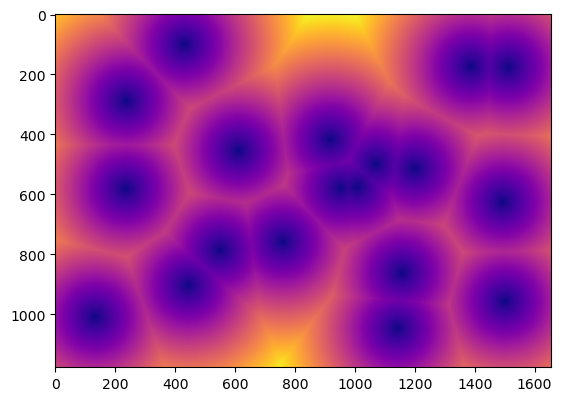

In [7]:
v = Vector.from_geojson("./data/03_example.geojson")
v = v.convert(r.getProjectionParameters())

d = v.mapDistance(30.0, bounds = r.getBounds())

# Plot raster
import matplotlib.pyplot as plt
plt.imshow(d.data, interpolation='none', cmap='plasma');

A radial basis function can be implemented using:

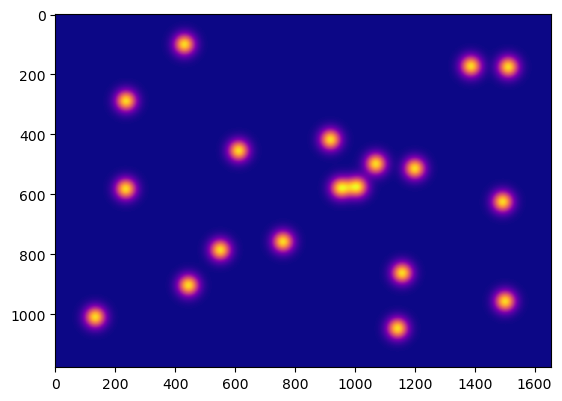

In [8]:
# Create distance map
d = v.mapDistance(30.0, bounds = r.getBounds(), script ='''
        REAL rb = exp(-1.0E-6*dot(d, d));
        output = isValid_REAL(output) ? output+rb : rb;
    ''')

# Plot raster
plt.imshow(d.data, interpolation='none', cmap='plasma');

where _output_ is the resulting map value and _d_ is the distance vector. The output is initially nodata, and is checked to see if it has been written to already, hence the _isValid_REAL_.

An inverse distance weighting can be implemented using:

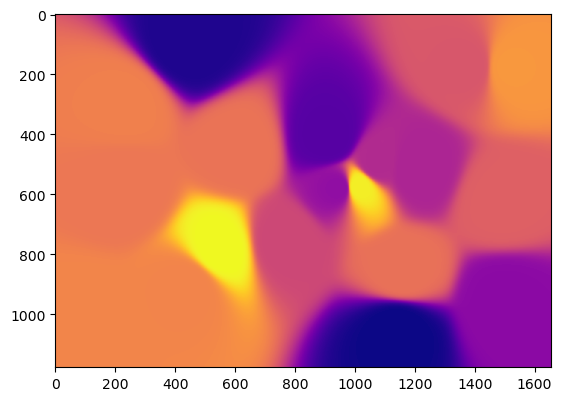

In [9]:
# Add random value to points
import random
v.addProperty("value")
for idx in v.getGeometryIndexes():
    v.setProperty(idx, "value", random.uniform(0.0, 1.0))

# Create distance map
d = v.mapDistance(30.0, bounds = r.getBounds(), script ='''
        REAL iDist = pow(length(d)+1.0E-6, -8.0);
        if (isValid_REAL(output)) {
            denom += iDist;
            output += value*iDist;
        } else {
            denom = iDist;
            output = value*iDist;
        }
    ''')

# Plot raster
plt.imshow(d.data, interpolation='none', cmap='plasma');

where a random value has been assigned to each point. The script uses _denom_, which is another reserved variable that holds a denominator. The output is divided by this value after running through all geometry elements.

### Rasterisation

Vectors can also be directly mapped to a Raster layer using the rasterise _function_. The rules for this are:
- Cells containing points are mapped
- Any cells that contain a line are mapped
- Any cells contained within a polygon are mapped.

An example of mapping the polygons in the previous example over the domain of the land classification layer is:

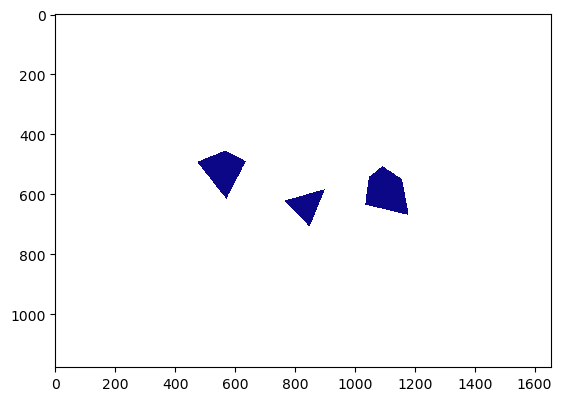

In [10]:
r.read("./data/02_example.tif")

v = Vector.from_geojson("./data/01_example.geojson")
v = v.convert(r.getProjectionParameters())

d = v.rasterise(30.0, bounds = r.getBounds())

plt.imshow(d.data, interpolation='none', cmap='plasma');

By default _rasterise_ sets any mapped values to 1 with nodata in all non-mapped cells. The rasterise function can use an optional script to define any other mapping required. This uses the reserved output variable to set the output value of the cell, and can reference any numeric property in the Vector:

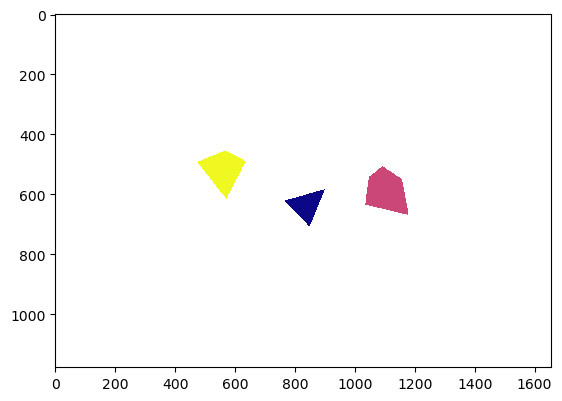

In [11]:
# Add new property set to index
v.addProperty ("var3")
for idx in v.getGeometryIndexes():
    v.setProperty(idx, 'var3', idx)

# Rasterise
d = v.rasterise(30.0, bounds = r.getBounds(), script = "output = var2+var3")

# Plot raster
plt.imshow(d.data, interpolation='none', cmap='plasma');

Rasterisation runs over all geometry elements overlapping the cell, and allows basic handling of multiple values for properties in the cell. For example, for the overlapping polygons shown below:

![image](https://gitlab.com/geostack/library/-/wikis/uploads/337a31f21290a6a95597e2018cf17c82/image.png)

The maximum value from all overlapping polygons can be found using:

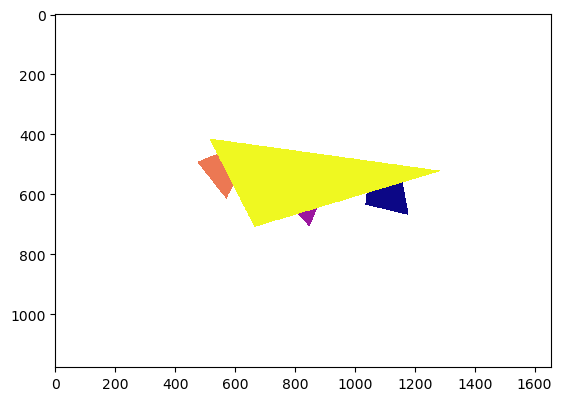

In [12]:
# Read data
v1 = Vector.from_geojson("./data/01_example.geojson")
v1 = v1.convert(r.getProjectionParameters())

v2 = Vector.from_geojson("./data/04_example.geojson")
v2 = v2.convert(r.getProjectionParameters())

v1 += v2

# Rasterise
d = v1.rasterise(30.0, bounds = r.getBounds(), script = "output = max(var2, output)")

# Plot raster
plt.imshow(d.data, interpolation='none', cmap='plasma');

A count value is provided in the script storing the current count of geometry elements overlapping the cell. This can be used to perform moving averages of the property value:

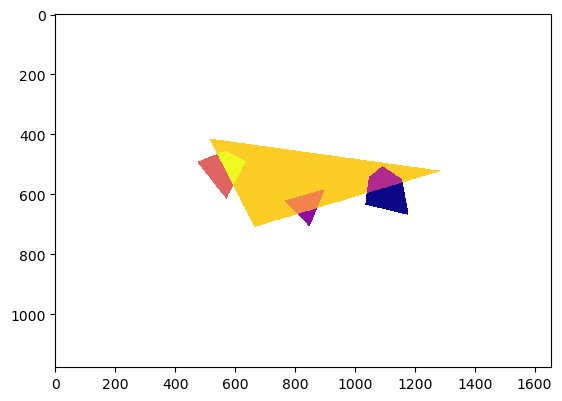

In [13]:
# Rasterise
d = v1.rasterise(30.0, bounds = r.getBounds(), script =  '''
    if (isValid_REAL(output))
        output += var2/(REAL)(count+1);
    else
        output = var2;
    ''')

# Plot raster
plt.imshow(d.data, interpolation='none', cmap='plasma');

### Vectorisation

A Vector can be created from a Raster using the _vectorise_ function. This can take an array of values, returning a contour along an isoline. Using the distance map example above, we can create a set of lines at a set of distances from the points using:

In [14]:
r.read("./data/02_example.tif")

v = Vector.from_geojson("./data/01_example.geojson")
v = v.convert(r.getProjectionParameters())

d = v.mapDistance(30.0, bounds = r.getBounds())

iso = d.vectorise([1000, 2000, 3000, 4000, 5000])

![image](https://gitlab.com/geostack/library/-/wikis/uploads/64346df0e4636d5a27021f781deb4739/image.png)

The vectorise function returns a set of lines, but can be converted into polygons if needed using the geometry _conversion _convert_ function:

In [15]:
from geostack.definitions import GeometryType

iso = iso.convert(GeometryType.Polygon)

![image](https://gitlab.com/geostack/library/-/wikis/uploads/b557bf20e37d282997c7a5ee52ef6ad2/image.png)